In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split , RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2837 non-null   float64
 1   Stage_fear                 2827 non-null   object 
 2   Social_event_attendance    2838 non-null   float64
 3   Going_outside              2834 non-null   float64
 4   Drained_after_socializing  2848 non-null   object 
 5   Friends_circle_size        2823 non-null   float64
 6   Post_frequency             2835 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB


In [5]:
def percent_missing(df):
    percent_nan = 100 * data.isna().sum()/len(data)
    percent_nan = percent_nan[percent_nan >0].sort_values()
    return percent_nan

missing_values = percent_missing(data)
missing_values


Drained_after_socializing    1.793103
Social_event_attendance      2.137931
Time_spent_Alone             2.172414
Post_frequency               2.241379
Going_outside                2.275862
Stage_fear                   2.517241
Friends_circle_size          2.655172
dtype: float64

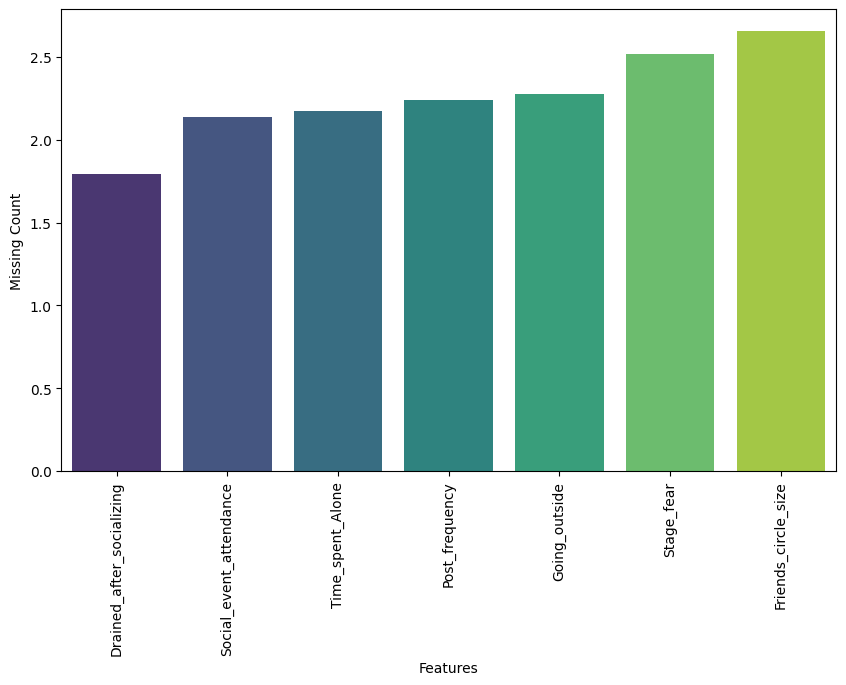

In [6]:
plt.figure(figsize=(10,6))
sns.barplot(x= missing_values.index,y= missing_values.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Missing Count');

In [7]:
num_feat = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
       'Friends_circle_size', 'Post_frequency']
cat_feat = ['Stage_fear', 'Drained_after_socializing']
target = 'Personality'

In [8]:
for col in cat_feat:
    print(f"{col} : {data[col].unique()}")
    print(f"{data[col].value_counts()}\n")

Stage_fear : ['No' 'Yes' nan]
Stage_fear
No     1417
Yes    1410
Name: count, dtype: int64

Drained_after_socializing : ['No' 'Yes' nan]
Drained_after_socializing
No     1441
Yes    1407
Name: count, dtype: int64



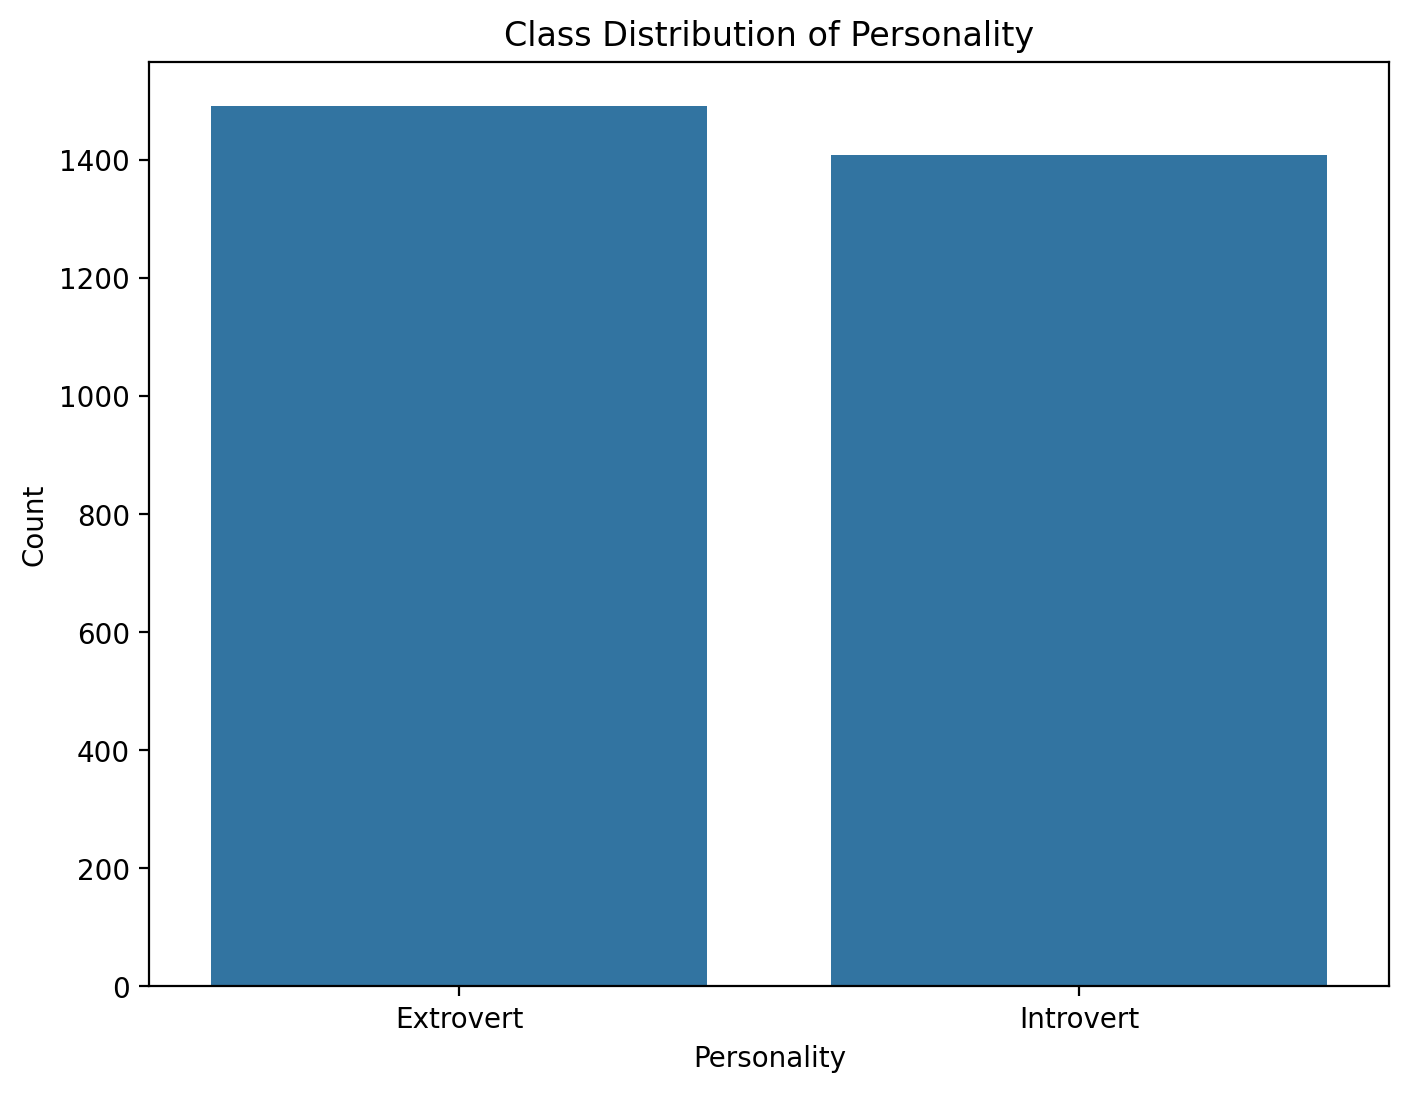

In [9]:
plt.figure(figsize=(8,6),dpi=200)
sns.countplot(x=target,data=data)
plt.title('Class Distribution of Personality')
plt.xlabel('Personality')
plt.ylabel('Count')
plt.show()

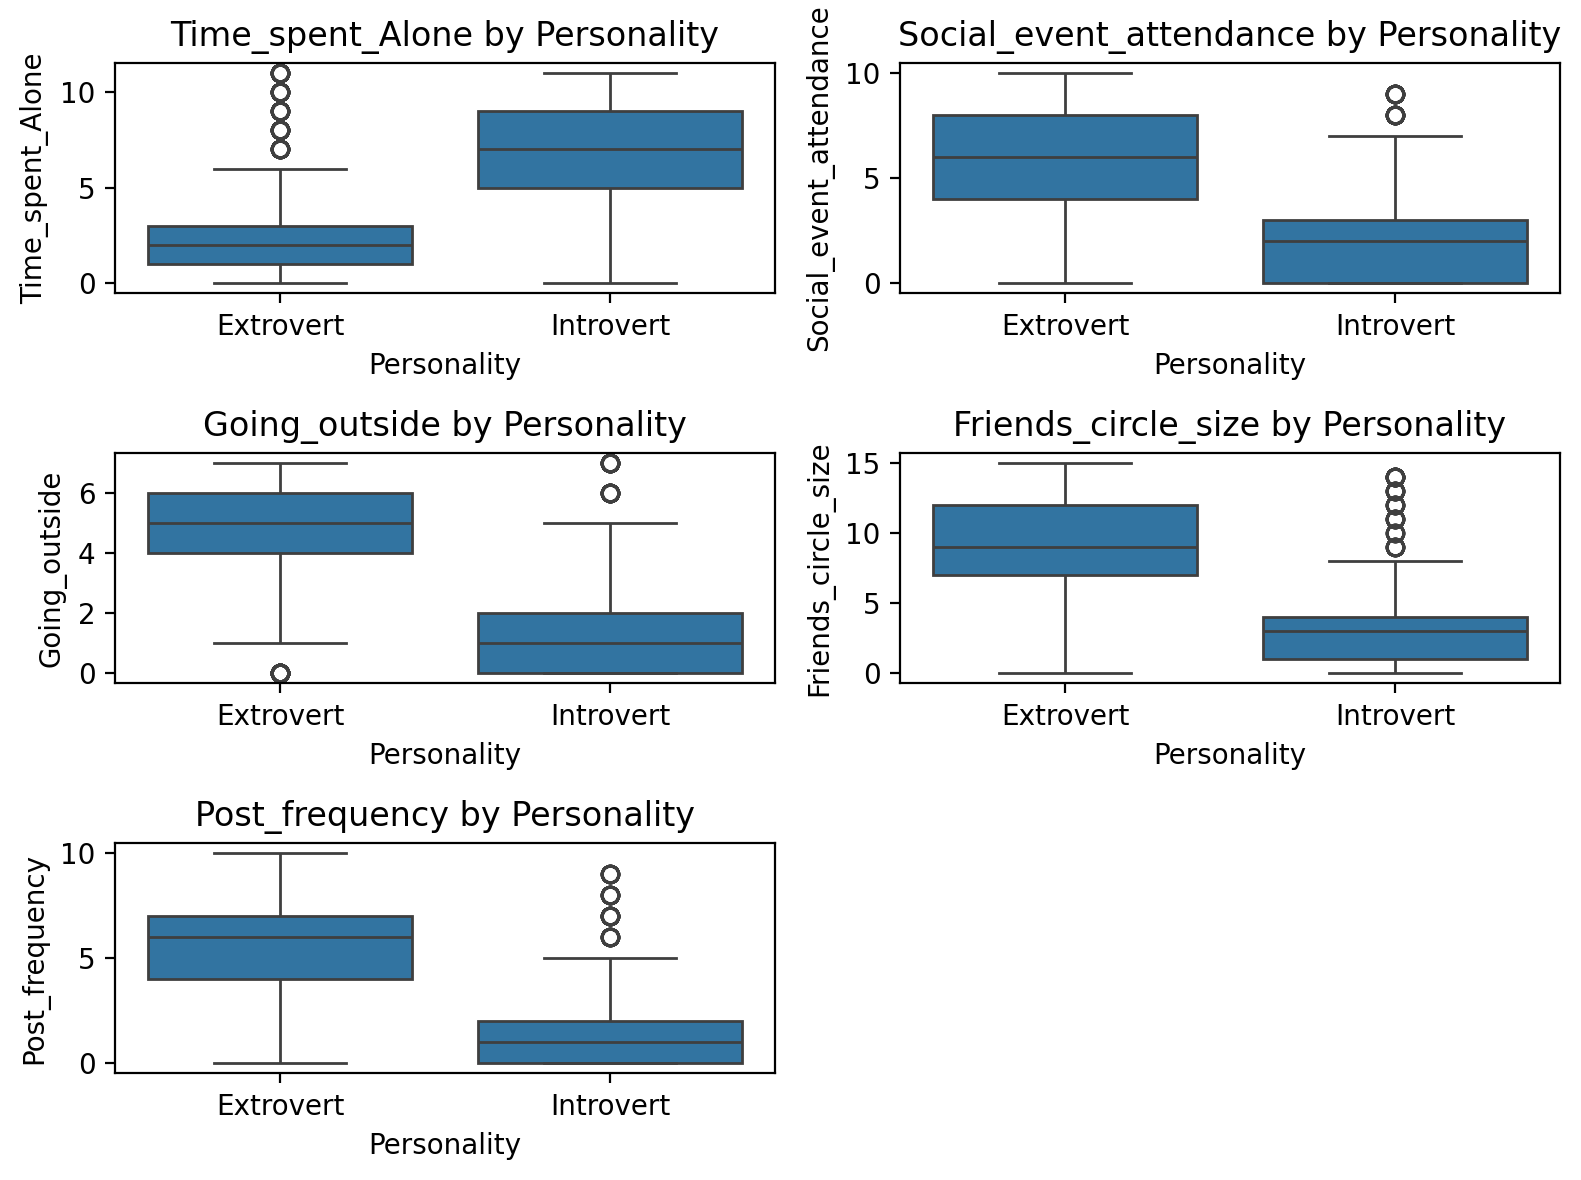

In [10]:
plt.figure(figsize=(8,6),dpi=200)
for i, col in enumerate(num_feat,1):
    plt.subplot(3,2,i)
    sns.boxplot(x=target,y=col,data=data)
    plt.title(f'{col} by Personality')
plt.tight_layout()
plt.show()

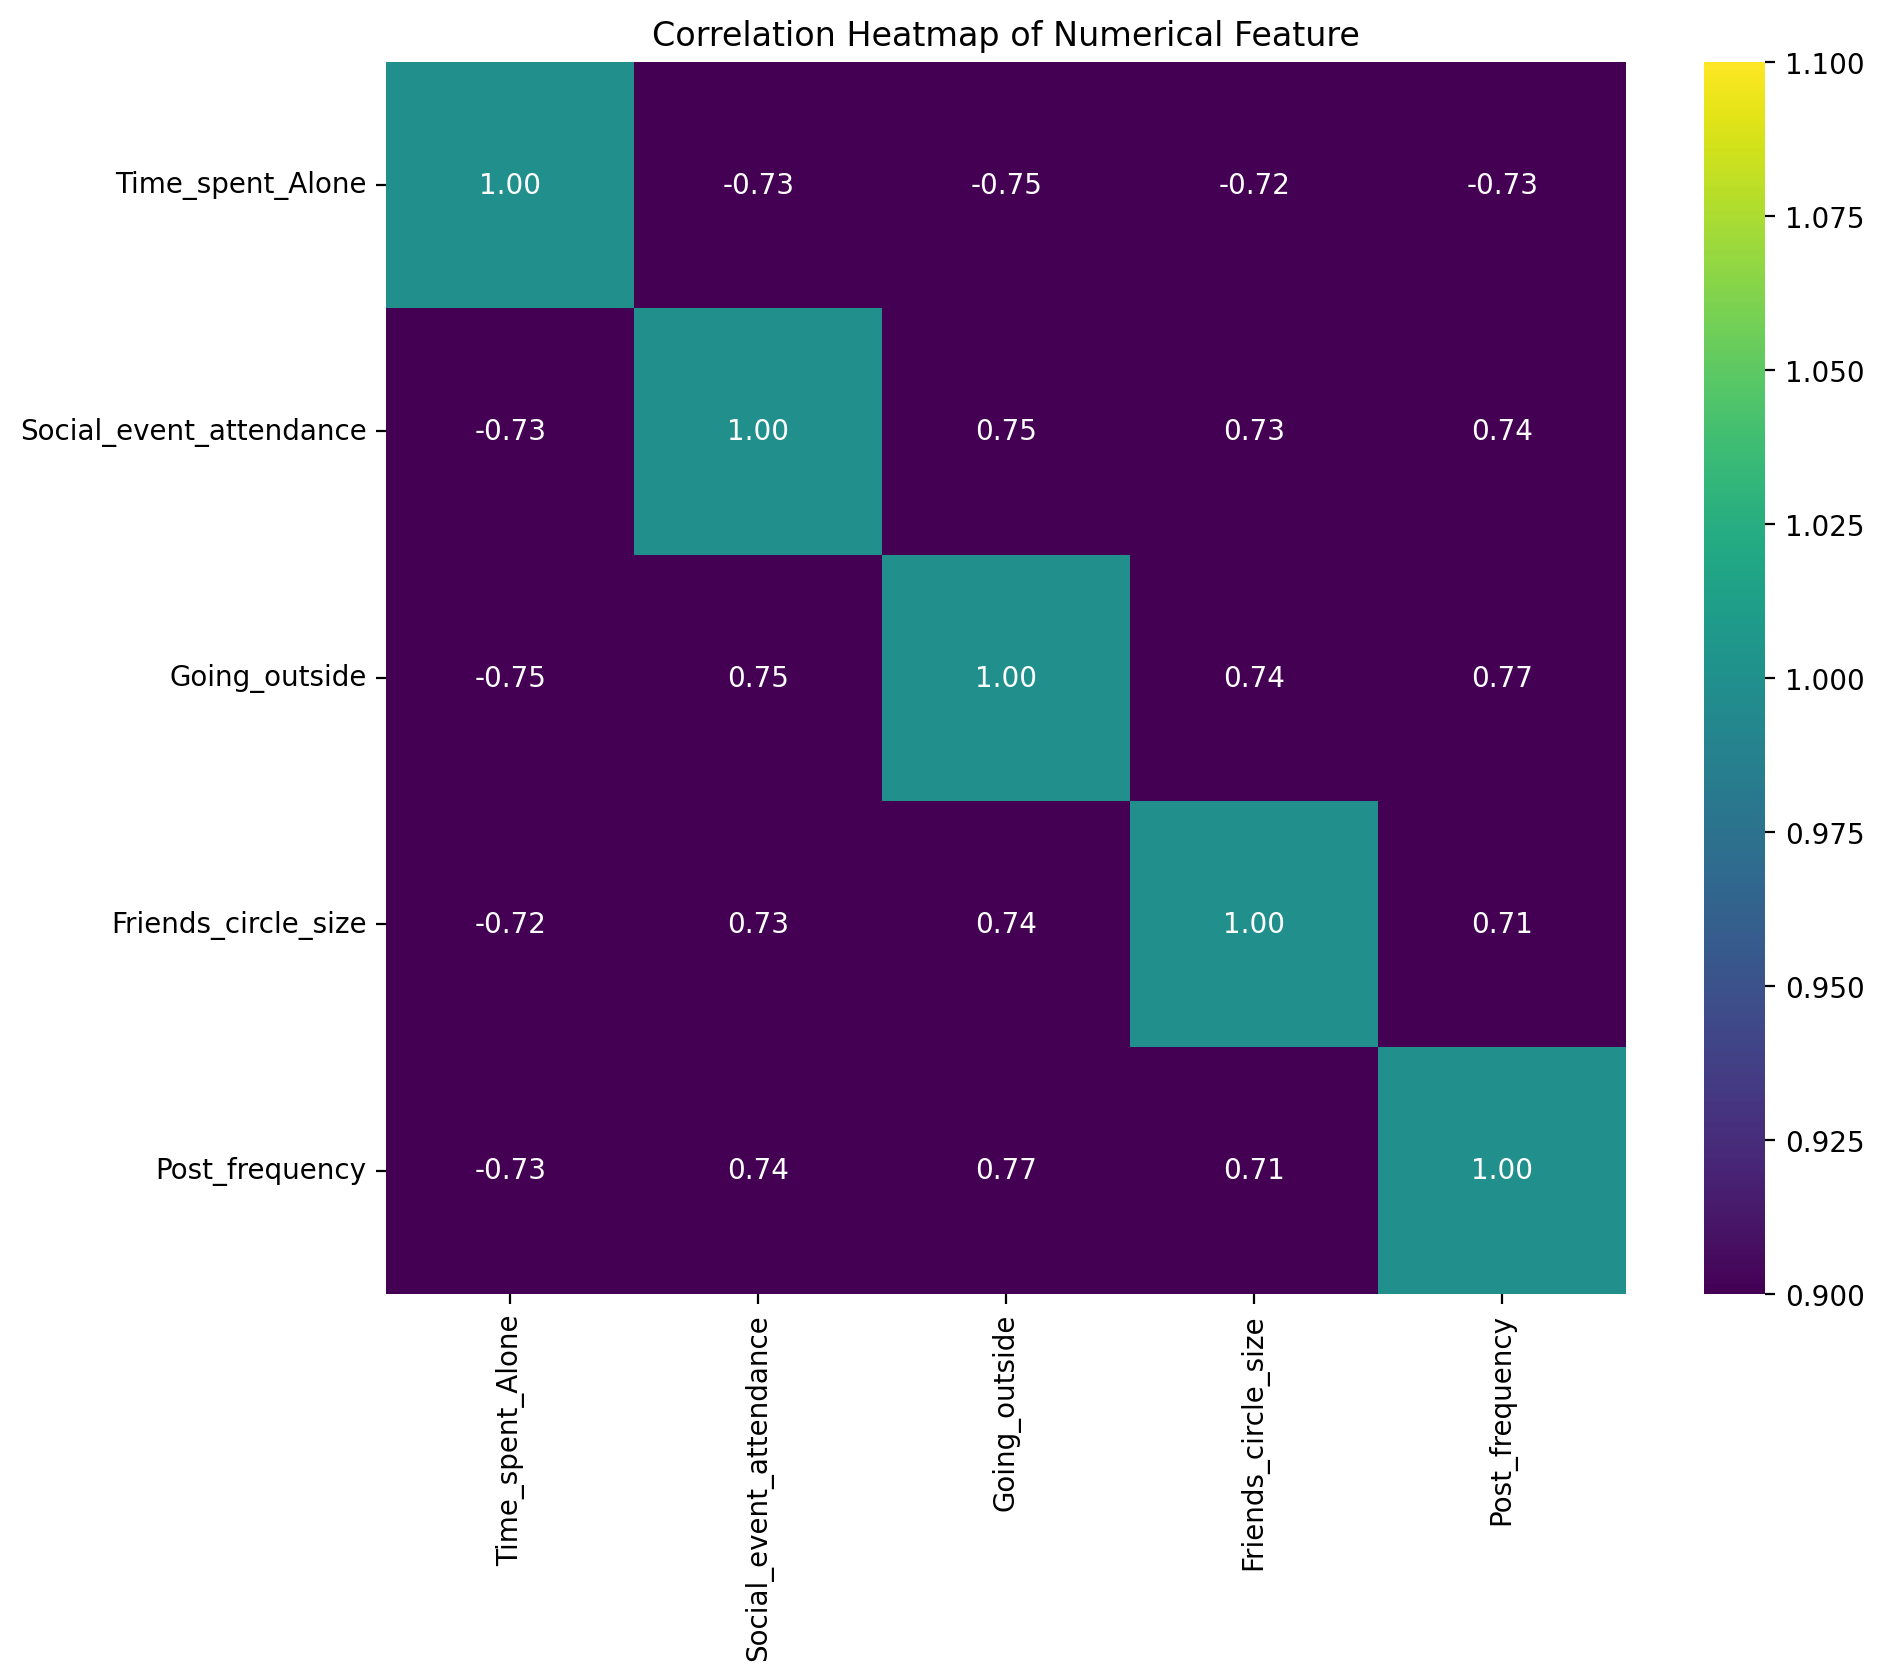

In [11]:
plt.figure(figsize=(10,8),dpi=200)
sns.heatmap(data[num_feat].corr(),annot=True,cmap='viridis',fmt='.2f',vmin=1,vmax=1)
plt.title("Correlation Heatmap of Numerical Feature")
plt.show()

In [12]:
le = LabelEncoder()
data[target] = le.fit_transform(data[target])
print(f"Encoded classes: {dict(zip(le.classes_,le.transform(le.classes_)))}")

# numerical feature imputation
num_impute = SimpleImputer(strategy='median')
data[num_feat] = num_impute.fit_transform(data[num_feat])

# categorical feature imputation
cat_impute = SimpleImputer(strategy='most_frequent')
data[cat_feat] = cat_impute.fit_transform(data[cat_feat])

# categorical feature encoding

data = pd.get_dummies(data,columns=cat_feat,drop_first=True)

enc_cols = [col for col in data.columns if col != target]


for col in num_feat:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3-q1
    lw_bnd = q1 - 1.5*iqr
    up_bnd = q3 + 1.5*iqr
    data[col] = data[col].clip(lower=lw_bnd,upper=up_bnd)




Encoded classes: {'Extrovert': np.int64(0), 'Introvert': np.int64(1)}


In [13]:
X = data.drop(columns=[target])
y = data[target]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42,stratify=y)

In [14]:
# handoling the imbalance with smote 
smote = SMOTE(random_state=42)
X_train,y_train = smote.fit_resample(X_train,y_train)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)


In [15]:
params = {
    'n_estimators':[100,150,200,300],
    'max_depth':[2,4,6,7,10],
    'min_samples_split':[5,7,9],
    'criterion':['gini','entropy']
}

clf = RandomForestClassifier()
model = RandomizedSearchCV(estimator=clf,param_distributions=params,n_iter=10,cv=5,verbose= 1,random_state= 101,n_jobs = -1)
model.fit(X_train_sc,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestClassifier()
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'criterion': ['gini', 'entropy'], 'max_depth': [2, 4, ...], 'min_samples_split': [5, 7, ...], 'n_estimators': [100, 150, ...]}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",10
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchang

In [16]:
warnings.simplefilter(action='ignore', category=UserWarning)


best_model = model.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Confusion Matrix:\n {confusion_matrix(y_test,y_pred)}\n")
print(f"Classification Report:\n {classification_report(y_test,y_pred)}")

Confusion Matrix:
 [[267  31]
 [ 26 256]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.90       298
           1       0.89      0.91      0.90       282

    accuracy                           0.90       580
   macro avg       0.90      0.90      0.90       580
weighted avg       0.90      0.90      0.90       580



In [17]:
import pickle 
filename = 'rf_model.pkl'
pickle.dump(best_model,open(filename,'wb'))